## Predicting Chronic Kidney Disease in Patients

Chronic kidney disease (CKD), also known as chronic renal disease. Chronic kidney disease involves conditions that damage your kidneys and decrease their ability to keep you healthy.
You may develop complications like high blood pressure, anemia (low blood count), weak bones, poor nutritional health and nerve damage.
Early detection and treatment can often keep chronic kidney disease from getting worse.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

#### Project Goal
As a Research biostatistical data scientist at the nation's top hospitala is to develop a medical test that can improve upon our current diagnosis system for chronic kidney disease (CKD).

**Real-world problem:** Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem:** Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

### Import and Obtain Data

In [1]:
# Imports here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./chronic_kidney_disease_full.csv')
df.head(10)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd
5,60.0,90.0,1.015,3.0,0.0,NaN,NaN,notpresent,notpresent,74.0,...,39.0,7800.0,4.4,yes,yes,no,good,yes,no,ckd
6,68.0,70.0,1.010,0.0,0.0,NaN,normal,notpresent,notpresent,100.0,...,36.0,NaN,NaN,no,no,no,good,no,no,ckd
7,24.0,NaN,1.015,2.0,4.0,normal,abnormal,notpresent,notpresent,410.0,...,44.0,6900.0,5.0,no,yes,no,good,yes,no,ckd
8,52.0,100.0,1.015,3.0,0.0,normal,abnormal,present,notpresent,138.0,...,33.0,9600.0,4.0,yes,yes,no,good,no,yes,ckd
9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,...,29.0,12100.0,3.7,yes,yes,no,poor,no,yes,ckd


### Visualize Missing values

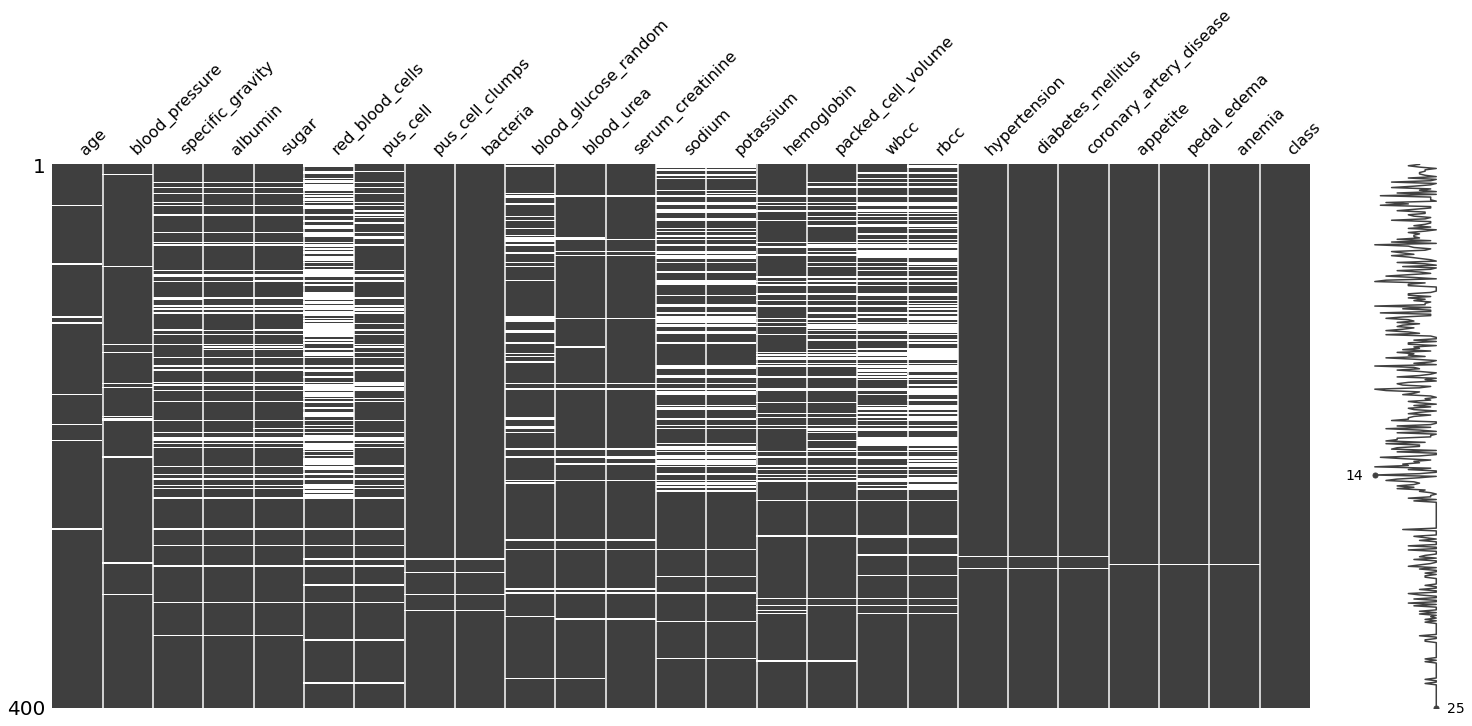

In [46]:
import missingno as msno
msno.matrix(df);
plt.savefig('./Reports/Missing_no.png')

> Missing values are constant throughout various features and dropping them wouldn't be beneficial for modeling, but let's take a look at our data, before making any decisions.

In [4]:
# Percentage of missing values
((df.isnull().sum()/df.shape[0])*100).sort_values(ascending=False)

rbc      38.00
rbcc     32.75
wbcc     26.50
pot      22.00
sod      21.75
pcv      17.75
pc       16.25
hemo     13.00
su       12.25
sg       11.75
al       11.50
bgr      11.00
bu        4.75
sc        4.25
bp        3.00
age       2.25
ba        1.00
pcc       1.00
htn       0.50
dm        0.50
cad       0.50
appet     0.25
pe        0.25
ane       0.25
class     0.00
dtype: float64

### Baseline for Class

In [5]:
df['class'].value_counts(normalize = True)

ckd       0.625
notckd    0.375
Name: class, dtype: float64

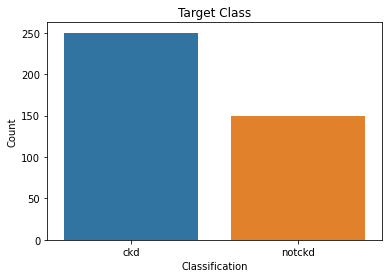

In [6]:
sns.countplot(x='class',data=df)
plt.xlabel("Classification")
plt.ylabel("Count")
plt.title("Target Class")
plt.show()

### Rename for easier identifiable columns

In [7]:
col={"bp":"blood_pressure",
          "sg":"specific_gravity",
          "al":"albumin",
          "su":"sugar",
          "rbc":"red_blood_cells",
          "pc":"pus_cell",
          "pcc":"pus_cell_clumps",
          "ba":"bacteria",
          "bgr":"blood_glucose_random",
          "bu":"blood_urea",
          "sc":"serum_creatinine",
          "sod":"sodium",
          "pot":"potassium",
          "hemo":"hemoglobin",
          "pcv":"packed_cell_volume",
          "wc":"white_blood_cell_count",
          "rc":"red_blood_cell_count",
          "htn":"hypertension",
          "dm":"diabetes_mellitus",
          "cad":"coronary_artery_disease",
          "appet":"appetite",
          "pe":"pedal_edema",
          "ane":"anemia"}

df.rename(columns=col, inplace=True)

In [8]:
df.head()

,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,packed_cell_volume,wbcc,rbcc,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,pedal_edema,anemia,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


### Each column unique values

In [9]:
for i in df.columns:
    print('{} unique values: {}.'.format(i, df[i].unique()), '\n')

age unique values: [48.  7. 62. 51. 60. 68. 24. 52. 53. 50. 63. 40. 47. 61. 21. 42. 75. 69.
 nan 73. 70. 65. 76. 72. 82. 46. 45. 35. 54. 11. 59. 67. 15. 55. 44. 26.
 64. 56.  5. 74. 38. 58. 71. 34. 17. 12. 43. 41. 57.  8. 39. 66. 81. 14.
 27. 83. 30.  4.  3.  6. 32. 80. 49. 90. 78. 19.  2. 33. 36. 37. 23. 25.
 20. 29. 28. 22. 79.]. 

blood_pressure unique values: [ 80.  50.  70.  90.  nan 100.  60. 110. 140. 180. 120.]. 

specific_gravity unique values: [1.02  1.01  1.005 1.015   nan 1.025]. 

albumin unique values: [ 1.  4.  2.  3.  0. nan  5.]. 

sugar unique values: [ 0.  3.  4.  1. nan  2.  5.]. 

red_blood_cells unique values: [nan 'normal' 'abnormal']. 

pus_cell unique values: ['normal' 'abnormal' nan]. 

pus_cell_clumps unique values: ['notpresent' 'present' nan]. 

bacteria unique values: ['notpresent' 'present' nan]. 

blood_glucose_random unique values: [121.  nan 423. 117. 106.  74. 100. 410. 138.  70. 490. 380. 208.  98.
 157.  76.  99. 114. 263. 173.  95. 108. 156. 264. 1

### Creating interaction terms
> Since pus cell and pus cell clumps and red and white blood cell are probably related.

In [10]:
df['pc_pcc_interaction'] = [1 if df.loc[i, 'pus_cell'] == 'abnormal' and 
                            df.loc[i, 'pus_cell_clumps'] == 'present' else 
                            0 for i in range(len(df['pus_cell']))]

In [11]:
df['wbcc_rbcc_interaction'] = df['wbcc'] * df['rbcc']

In [12]:
df['pcv_hemo_interaction'] = df['packed_cell_volume'] * df['hemoglobin']

### Feature Correlation with class

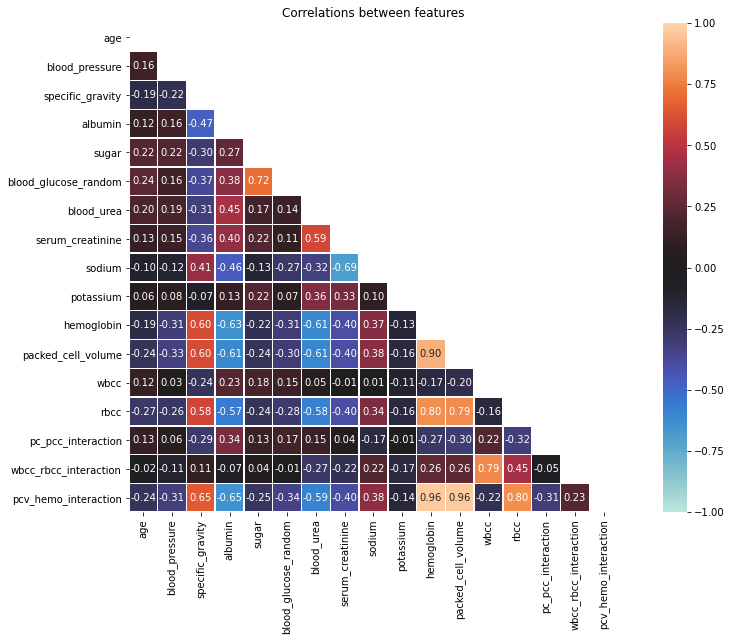

<Figure size 432x288 with 0 Axes>

In [13]:
plt.figure(figsize=(16,9))
# Set up mask to be "True" in the upper triangle.
corr_df = df.corr()
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True

# Plot our correlation heatmap, while masking the upper triangle to be white.
ax = sns.heatmap(
    corr_df, 
    mask=mask, # mask the upper half
    square=True, 
    annot=True, fmt=".2f",
    vmin=-1, 
    vmax=1, 
    center=0, 
    linewidths=.5
)
plt.title('Correlations between features')
plt.show();
plt.savefig('./Reports/corr_btw_features.jpg')

### Correlations to look further:
>packed cell volume vs hemoglobin - .90<br>
rbcc vs hemomglobin - .8


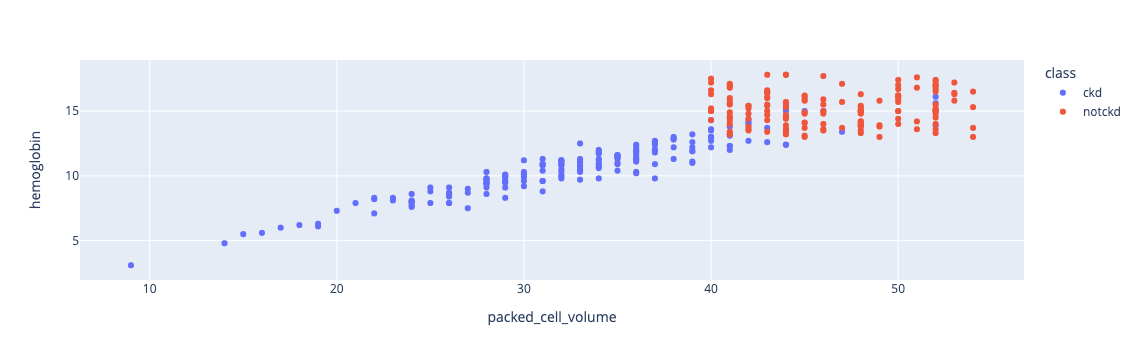

In [14]:
fig = px.scatter(df, x="packed_cell_volume", y="hemoglobin", color="class")
fig.show()

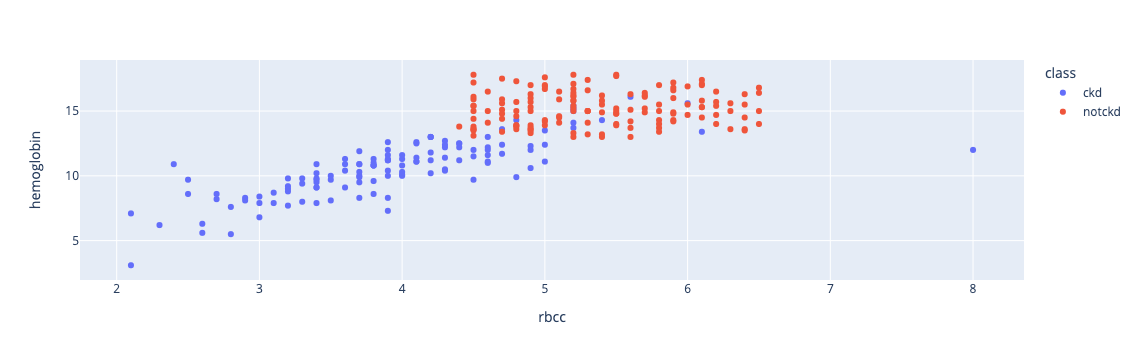

In [15]:
fig = px.scatter(df, x="rbcc", y="hemoglobin", color="class")
fig.show()

#### obs: Interaction terms did not help. Should be dropped.

In [16]:
df.drop(axis = 1, columns= 
        ['pc_pcc_interaction', 'wbcc_rbcc_interaction', 'pcv_hemo_interaction'], inplace = True)

#### Overall View of numerical features

In [17]:
numerical_features = [feature for feature in df.columns if df[feature].dtypes == 'float64']

In [18]:
df[numerical_features].describe().T

,count,mean,std,min,25%,50%,75%,max
age,391.0,51.483376,17.169714,2.000,42.00,55.00,64.50,90.000
blood_pressure,388.0,76.469072,13.683637,50.000,70.00,80.00,80.00,180.000
specific_gravity,353.0,1.017408,0.005717,1.005,1.01,1.02,1.02,1.025
albumin,354.0,1.016949,1.352679,0.000,0.00,0.00,2.00,5.000
sugar,351.0,0.450142,1.099191,0.000,0.00,0.00,0.00,5.000
blood_glucose_random,356.0,148.036517,79.281714,22.000,99.00,121.00,163.00,490.000
blood_urea,381.0,57.425722,50.503006,1.500,27.00,42.00,66.00,391.000
serum_creatinine,383.0,3.072454,5.741126,0.400,0.90,1.30,2.80,76.000
sodium,313.0,137.528754,10.408752,4.500,135.00,138.00,142.00,163.000
potassium,312.0,4.627244,3.193904,2.500,3.80,4.40,4.90,47.000


### Distributions of each variable. Are there certain variables that overwhelmingly take on one value and thus might not be predictive?

In [19]:
def plot_kde(feature):
    plt = sns.FacetGrid(df, hue = 'class')
    plt.map(sns.kdeplot, feature)
    plt.add_legend()

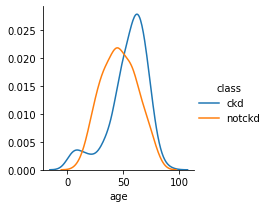

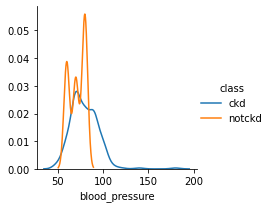

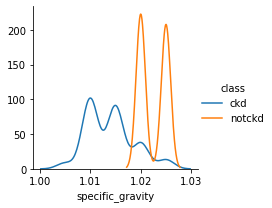

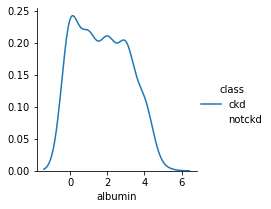

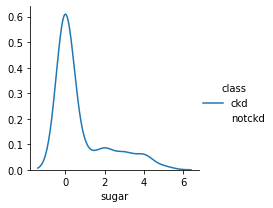

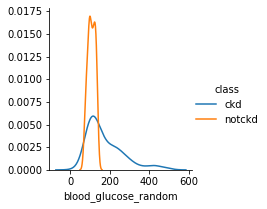

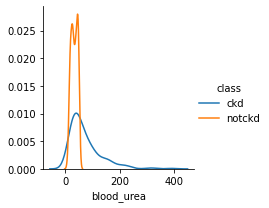

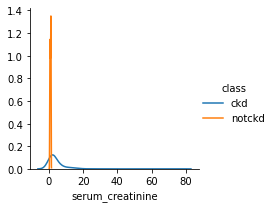

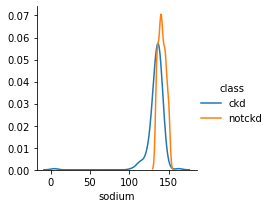

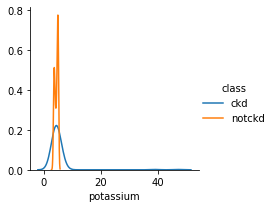

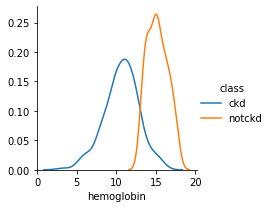

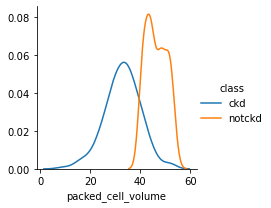

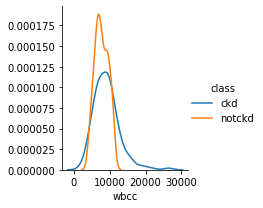

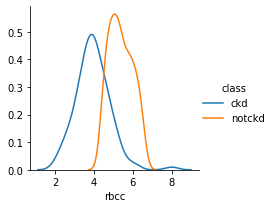

In [20]:
for i in numerical_features:
    plot_kde(i)

### Kde plot Analysis
> hemoglobin | packed_cell_volume | rbcc | pcv_hemo_interaction have:
> - less overlap than other features
> - ckd has a normal distibution, while not ckd is left-skewed

#### What does this mean?
- That less overlapping feautres have more predictive values 
- distributions of new ckd left-skewed is not a big issue, we hardly find data normally distributed.

## Separate quantitative and qualitative features for dummy variables

In [21]:
for i in df.columns:
    if i not in numerical_features:
        print(i)

red_blood_cells
pus_cell
pus_cell_clumps
bacteria
hypertension
diabetes_mellitus
coronary_artery_disease
appetite
pedal_edema
anemia
class


In [22]:
# Transforming each categorical features into ONE binary dummy variable
red_blood_cells_abnormal = pd.get_dummies(df['red_blood_cells'])['abnormal']
pus_cell_abnormal = pd.get_dummies(df['pus_cell'])['abnormal']
pus_cell_clumps_present = pd.get_dummies(df['pus_cell_clumps'])['present']
bacte_present = pd.get_dummies(df['bacteria'])['present']
hypert_yes = pd.get_dummies(df['hypertension'])['yes']
diab_mellitus_yes = pd.get_dummies(df['diabetes_mellitus'])['yes']
coro_artery_yes = pd.get_dummies(df['coronary_artery_disease'])['yes']
appet_poor = pd.get_dummies(df['appetite'])['poor']
pedal_edema_yes = pd.get_dummies(df['pedal_edema'])['yes']
anemia_yes = pd.get_dummies(df['anemia'])['yes']
df['class'] = [1 if i == 'ckd' else 0 for i in df['class']]

In [23]:
df.columns

Index(['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar',
       'red_blood_cells', 'pus_cell', 'pus_cell_clumps', 'bacteria',
       'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
       'potassium', 'hemoglobin', 'packed_cell_volume', 'wbcc', 'rbcc',
       'hypertension', 'diabetes_mellitus', 'coronary_artery_disease',
       'appetite', 'pedal_edema', 'anemia', 'class'],
      dtype='object')

In [25]:
quant = df[['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar', 'blood_glucose_random',
                 'blood_urea', 'serum_creatinine', 'sodium', 'potassium', 'hemoglobin', 'packed_cell_volume',
                 'wbcc', 'rbcc']]

qual = pd.DataFrame([anemia_yes, pedal_edema_yes, red_blood_cells_abnormal, pus_cell_abnormal,
                     pus_cell_clumps_present, bacte_present, hypert_yes, diab_mellitus_yes,
                     coro_artery_yes, appet_poor], index=['anemia_yes', 'pedal_edema_yes', 'red_blood_cells_abnormal',
                                                  'pus_cell_abnormal', 'pus_cell_clumps_present',
                                                  'bacte_present', 'hypert_yes', 'diab_mellitus_yes',
                                                  'coro_artery_yes', 'appet_poor']).T

In [26]:
X = quant.merge(right = qual, left_index = True, right_index = True)
y = df['class']
X.head()

,age,blood_pressure,specific_gravity,albumin,sugar,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,...,anemia_yes,pedal_edema_yes,red_blood_cells_abnormal,pus_cell_abnormal,pus_cell_clumps_present,bacte_present,hypert_yes,diab_mellitus_yes,coro_artery_yes,appet_poor
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,...,0,0,0,0,0,0,1,1,0,0
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,...,1,0,0,0,0,0,0,1,0,1
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,1,1,0,1,1,0,1,0,0,1
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


### Using Standard Scaler to understand our coefficients

In [27]:
y.unique()

array([1, 0])

In [28]:
# Train, test split but first we'll try robustly fill missing values with the mean

X_train, X_test, y_train, y_test = train_test_split(X.fillna(X.mean()), y,
                                                    test_size = 0.3, 
                                                    random_state = 42)

In [29]:
parameters = {'C': [0.001, 0.01, 0.1, 1, 10],
              'class_weight': [None, 'balanced'],
              'penalty': ['l1', 'l2']}

In [30]:
lr = LogisticRegression(solver = 'liblinear', 
                        max_iter = 1000,
                        random_state = 42)

In [31]:
gs_results = GridSearchCV(estimator = lr,                                    
                          param_grid = parameters,                           
                          scoring = 'recall',                                 
                          cv = 5).fit(X_train, y_train)

In [32]:
gs_results.best_estimator_

LogisticRegression(C=0.001, max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')

In [33]:
gs_results.best_estimator_.get_params()

{'C': 0.001,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

#### Based on the results of this GridSearch, our best model is that which:
- Balances our class_weight (weighting our y variables so each class makes up 50%)
- Has the L2 penalty (i.e. Ridge regression)

In [34]:
logit = LogisticRegression(solver = 'liblinear', 
                           max_iter = 1000,
                           C = 10,
                           class_weight = 'balanced',
                           penalty = 'l2',
                           random_state = 42)

In [35]:
logit.fit(X = X_train,
          y = y_train)

LogisticRegression(C=10, class_weight='balanced', max_iter=1000,
                   random_state=42, solver='liblinear')

## Evaluating the Model

In [36]:
logit.score(X_train, y_train)

0.9892857142857143

In [37]:
logit.score(X_test, y_test)

0.975

## Interpreting Coefficients

In [38]:
features = list(zip(np.exp(logit.coef_[0]), X.columns))
features

[(1.0092091385117612, 'age'),
 (1.1152223676915798, 'blood_pressure'),
 (1.2068728890518243, 'specific_gravity'),
 (36.028378749367285, 'albumin'),
 (3.1391842383580055, 'sugar'),
 (1.0357883668535819, 'blood_glucose_random'),
 (0.9247388361599155, 'blood_urea'),
 (11.228403839727452, 'serum_creatinine'),
 (1.0744188420985308, 'sodium'),
 (1.241379994332761, 'potassium'),
 (0.18355393325952232, 'hemoglobin'),
 (0.9955466397191362, 'packed_cell_volume'),
 (0.9998812884753627, 'wbcc'),
 (0.5057787103373003, 'rbcc'),
 (1.6387518141683795, 'anemia_yes'),
 (6.499597368192481, 'pedal_edema_yes'),
 (2.4268100892792264, 'red_blood_cells_abnormal'),
 (2.1051089315706832, 'pus_cell_abnormal'),
 (1.086727887702217, 'pus_cell_clumps_present'),
 (1.020698864350231, 'bacte_present'),
 (4.662182695539949, 'hypert_yes'),
 (4.789997542410086, 'diab_mellitus_yes'),
 (1.0654482237155483, 'coro_artery_yes'),
 (6.346766521273125, 'appet_poor')]

In [39]:
# Making it into a DataFrame and saving as Coefficient report
coef_df = pd.DataFrame(features, columns = ['Coefficient', 'features'])
coef_df = coef_df.sort_values(by= ['Coefficient'], ascending = False)
coef_df.to_csv('./Reports/Coefficients.csv')

In [45]:
coef_df

,Coefficient,features
3,36.028379,albumin
7,11.228404,serum_creatinine
15,6.499597,pedal_edema_yes
23,6.346767,appet_poor
21,4.789998,diab_mellitus_yes
20,4.662183,hypert_yes
4,3.139184,sugar
16,2.426810,red_blood_cells_abnormal
17,2.105109,pus_cell_abnormal
14,1.638752,anemia_yes


## Coefficient Interpretations
> - As serum creatinine increases by one unit (mgs/dl), an individual is 11.65 times as likely to have CKD, all else held equal.
> - If someone's appetite is poor appet_poor, they are 4.57 times as likely to have CKD, all else held equal.
> - If someone's pedal_edema is positive, they are 5.4 times as likely to have CKD, all else held equal.
> - If someone's hypertension or diabetes mellitus is positive, they are about 4 times as likely to have CKD, all else held equal.

In [40]:
y_preds = logit.predict(X_test)

### Generate a Confusion matrix to evaluate our predictions

In [41]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()

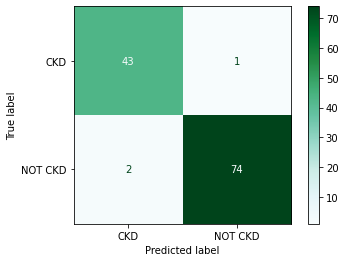

In [42]:
metrics.plot_confusion_matrix(logit, X_test, y_test, cmap = 'BuGn', display_labels = ['CKD', 'NOT CKD']);
plt.savefig('./Reports/Confusion_matrix.png')

In [43]:
from sklearn.metrics import classification_report

In [44]:
print(classification_report(y_test,
                            logit.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        44
           1       0.99      0.97      0.98        76

    accuracy                           0.97       120
   macro avg       0.97      0.98      0.97       120
weighted avg       0.98      0.97      0.98       120



## Conclusions

Present this model to doctors or administrators at the hospital and show how the model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!

> - Try a different method of upsampling minority class
> - Already tried simple imputter but performed worst than imputing with the mean. (Although it's unexpected)